In [5]:
# https://hotspot.readthedocs.io/en/latest/Lineage_Tutorial.html
# https://colab.research.google.com/drive/1UArV6s-3JN2nKuHcsjfsYu33elR1ySa6#scrollTo=Dj24KOME2K6l

import sys
import warnings; warnings.simplefilter('ignore')

import hotspot
import scanpy as sc

import numpy as np
import mplscience

import anndata as ad

In [6]:
adata = ad.read_h5ad("/home/users/kzlin/kzlinlab/projects/scContrastiveLearn/out/kevin/Writeup5/Larry_41093_2000_norm_log.h5ad")
adata

AnnData object with n_obs × n_vars = 41093 × 2000
    obs: 'Library', 'Cell barcode', 'time_info', 'Starting population', 'state_info', 'Well', 'SPRING-x', 'SPRING-y', 'Time point', 'clone_id', 'n_genes'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'data_des', 'hvg', 'log1p'
    obsm: 'X_clone', 'X_emb'
    layers: 'ambiguous', 'matrix', 'raw_counts', 'spliced', 'unspliced'

In [7]:
adata.layers["raw_counts"].shape

(41093, 2000)

In [8]:
scCL_embedding = np.load("/home/users/kzlin/kzlinlab/projects/scContrastiveLearn/out/kevin/Writeup5/scBaseEncoderFeat_Z_bs260_tau0.5.npy")
scCL_embedding.shape

(41093, 64)

In [9]:
adata.obsm["X_scCL"] = scCL_embedding

# Verify the assignment
print(adata.obsm["X_scCL"].shape)

(41093, 64)


In [10]:
sc.pp.calculate_qc_metrics(adata, inplace=True)
sc.pp.filter_genes(adata, min_cells=1)

Run Hotspot

In [11]:
adata.layers["raw_counts_csc"] = adata.layers["raw_counts"].tocsc()

In [12]:
# Create the Hotspot object with latent embeddings and normalized data

hs = hotspot.Hotspot(
    adata,
    layer_key="raw_counts_csc",
    model='danb',
    latent_obsm_key="X_scCL"
)

In [13]:
# Create the neighborhood graph
hs.create_knn_graph(
    weighted_graph=False, n_neighbors=30,
)

Determining informative genes

In [14]:
# Determine informative genes
hs_results = hs.compute_autocorrelations(jobs=4)
print(hs_results.head(15))

100%|██████████| 2000/2000 [00:04<00:00, 429.60it/s]


                 C            Z  Pval  FDR
Gene                                      
Dlk1      0.334033  1431.151245   0.0  0.0
H2afy     0.475389  1178.023560   0.0  0.0
Gm15915   0.360901  1104.918213   0.0  0.0
Cd34      0.340873  1000.851196   0.0  0.0
Igfbp4    0.428947   988.002625   0.0  0.0
Car2      0.277479   859.690125   0.0  0.0
Podxl     0.318105   816.035767   0.0  0.0
Ly6d      0.172142   733.042114   0.0  0.0
Muc13     0.279079   716.965088   0.0  0.0
Car1      0.202019   663.801086   0.0  0.0
Ly6a      0.350633   652.938660   0.0  0.0
Gmpr      0.300175   648.636719   0.0  0.0
Tmem176b  0.247135   634.917053   0.0  0.0
Gata2     0.465717   634.299744   0.0  0.0
Scin      0.280332   520.328308   0.0  0.0


In [15]:
print(hs_results.tail(15))

                      C         Z      Pval       FDR
Gene                                                 
Hnf4a         -0.000525 -1.187776  0.882539  0.888761
Gm11696       -0.001055 -1.204931  0.885885  0.891681
Gm11992       -0.001013 -1.226275  0.889952  0.895324
Gzmm          -0.000669 -1.247006  0.893802  0.898745
Ankrd13d      -0.001346 -1.346349  0.910905  0.915482
Rmdn2         -0.001379 -1.416170  0.921637  0.925765
Abca5         -0.001161 -1.419080  0.922062  0.925765
Dopey1        -0.001166 -1.450032  0.926475  0.929729
BC024386      -0.000702 -1.496248  0.932706  0.935512
Actg1         -0.000996 -1.507209  0.934121  0.936463
C920025E04Rik -0.001389 -1.700877  0.955517  0.957432
Pdk2          -0.001285 -1.784232  0.962807  0.964253
Zc3hav1       -0.001336 -1.808466  0.964733  0.965699
Plekhg4       -0.001242 -2.026111  0.978623  0.979113
Gm4262        -0.001722 -2.050745  0.979854  0.979854


In [17]:
type(hs_results)

pandas.core.frame.DataFrame

In [18]:
import pandas as pd

# Assuming df is your DataFrame
hs_results.to_csv('/home/users/kzlin/kzlinlab/projects/scContrastiveLearn/out/kevin/Writeup5/Writeup5_LARRY_LCL_hotspot_autocorrelations.csv')  

Grouping genes into lineage-based modules

In [19]:
# Select the genes with significant lineage autocorrelation
hs_genes = hs_results.loc[hs_results.FDR < 0.05].sort_values('Z', ascending=False).head(500).index

# Compute pair-wise local correlations between these genes
lcz = hs.compute_local_correlations(hs_genes, jobs=4)


Computing pair-wise local correlation on 500 features...


100%|██████████| 124750/124750 [01:49<00:00, 1140.57it/s]


In [20]:
modules = hs.create_modules(
    min_gene_threshold=15, core_only=True, fdr_threshold=0.05
)

modules.value_counts()

Module
 4     83
 3     81
 1     79
-1     76
 6     38
 7     36
 8     29
 9     24
 2     23
 10    16
 5     15
Name: count, dtype: int64

In [23]:
print(modules)
print(type(modules))

Dlk1       4
H2afy      4
Gm15915    2
Cd34       4
Igfbp4     4
          ..
Il1b      -1
Kmo        7
Ffar2      3
Nt5e      -1
Atp1b1     7
Name: Module, Length: 500, dtype: int64
<class 'pandas.core.series.Series'>


In [35]:
modules.to_csv('/home/users/kzlin/kzlinlab/projects/scContrastiveLearn/out/kevin/Writeup5/Writeup5_LARRY_LCL_hotspot_module-clustering.csv')

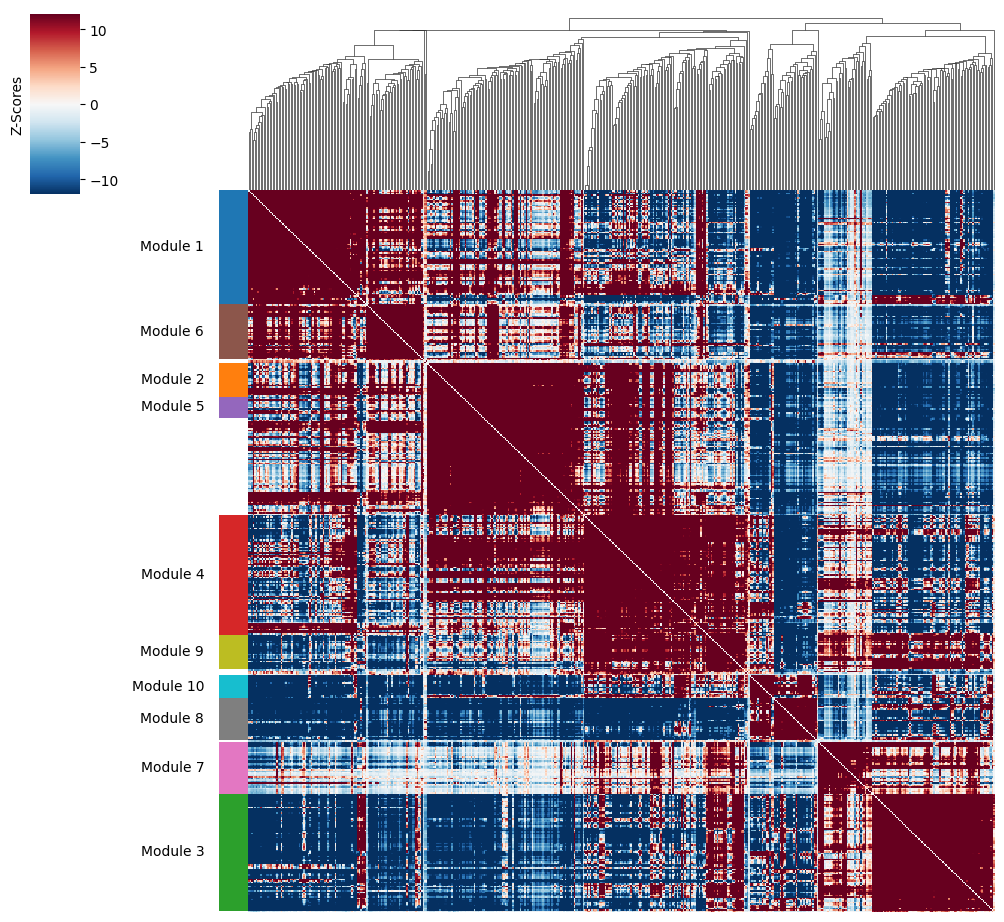

In [21]:
hs.plot_local_correlations(vmin=-12, vmax=12)

In [24]:
# Show the top genes for a module

module = 9

results = hs.results.join(hs.modules)
results = results.loc[results.Module == module]

results.sort_values('Z', ascending=False).head(10)

,C,Z,Pval,FDR,Module
Gene,,,,,
Ly6a,0.350633,652.938660,0.0,0.0,9.0
Trim30a,0.119406,194.441071,0.0,0.0,9.0
Ifi203,0.091475,150.649094,0.0,0.0,9.0
Irgm1,0.076655,130.961914,0.0,0.0,9.0
Isg15,0.059085,114.655708,0.0,0.0,9.0
Mndal,0.076973,110.412117,0.0,0.0,9.0
Epsti1,0.069704,109.782280,0.0,0.0,9.0
Tnfrsf1b,0.098969,108.151680,0.0,0.0,9.0
Irf9,0.069185,102.696678,0.0,0.0,9.0


Summary module scores

In [25]:
module_scores = hs.calculate_module_scores()

module_scores.head()

Computing scores for 10 modules...


100%|██████████| 10/10 [00:04<00:00,  2.36it/s]


,1,2,3,4,5,6,7,8,9,10
d6_2_2:GCGTGCAAAGAAGTTA,-0.776166,-0.340325,-1.696765,3.134601,0.325511,-0.595798,-0.441595,-0.613851,-0.588852,2.788298
d6_2_2:AAGGGACCCTCGATGC,-0.718726,-0.387137,-0.678661,6.670407,-0.090889,-0.602686,-0.136116,-1.339846,0.142885,0.148396
d6_2_2:CGTACCGAAGCGCCTT,-1.912905,-1.313112,5.954760,-1.971467,-0.628494,-0.804962,-0.107957,-0.542829,0.195072,-0.256240
d6_2_2:CCGTAGCTAGGCAGTT,1.823914,7.563347,-2.364623,2.482192,2.155099,2.092738,-0.514379,-1.149402,-0.811761,-1.307443
d6_2_2:TAGGCTTTCGTGGATA,-2.350100,-1.518409,0.754908,-1.975799,-0.685696,-0.913318,-0.457439,0.658983,-1.061215,1.261643


In [33]:
type(module_scores)

pandas.core.frame.DataFrame

In [34]:
module_scores.to_csv('/home/users/kzlin/kzlinlab/projects/scContrastiveLearn/out/kevin/Writeup5/Writeup5_LARRY_LCL_hotspot_module-scores.csv')

In [26]:
adata

AnnData object with n_obs × n_vars = 41093 × 2000
    obs: 'Library', 'Cell barcode', 'time_info', 'Starting population', 'state_info', 'Well', 'SPRING-x', 'SPRING-y', 'Time point', 'clone_id', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'data_des', 'hvg', 'log1p'
    obsm: 'X_clone', 'X_emb', 'X_scCL'
    layers: 'ambiguous', 'matrix', 'raw_counts', 'spliced', 'unspliced', 'raw_counts_csc'

In [27]:
module_cols = []
for c in module_scores.columns:
    key = f"Module {c}"
    adata.obs[key] = module_scores[c]
    module_cols.append(key)

In [29]:
adata.obsm['X_emb']

array([[ 411.496,  -96.19 ],
       [-587.462, -306.925],
       [1429.805, -429.3  ],
       ...,
       [ 247.634,  281.262],
       [ 353.734, -980.246],
       [2513.013, -324.061]])

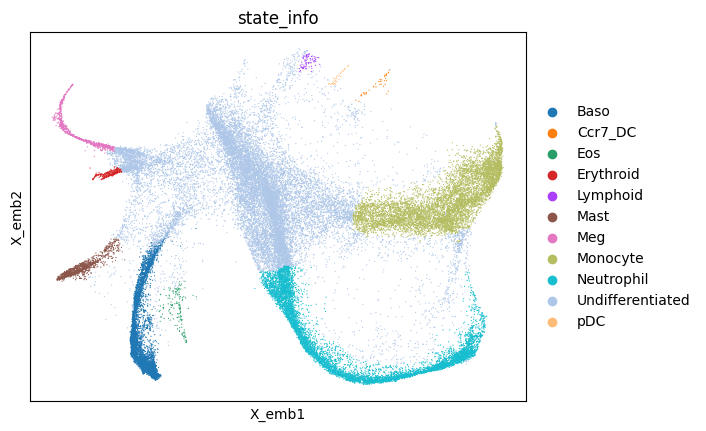

In [31]:
sc.pl.embedding(adata, basis='X_emb', color='state_info')  # Example coloring by 'state_info'

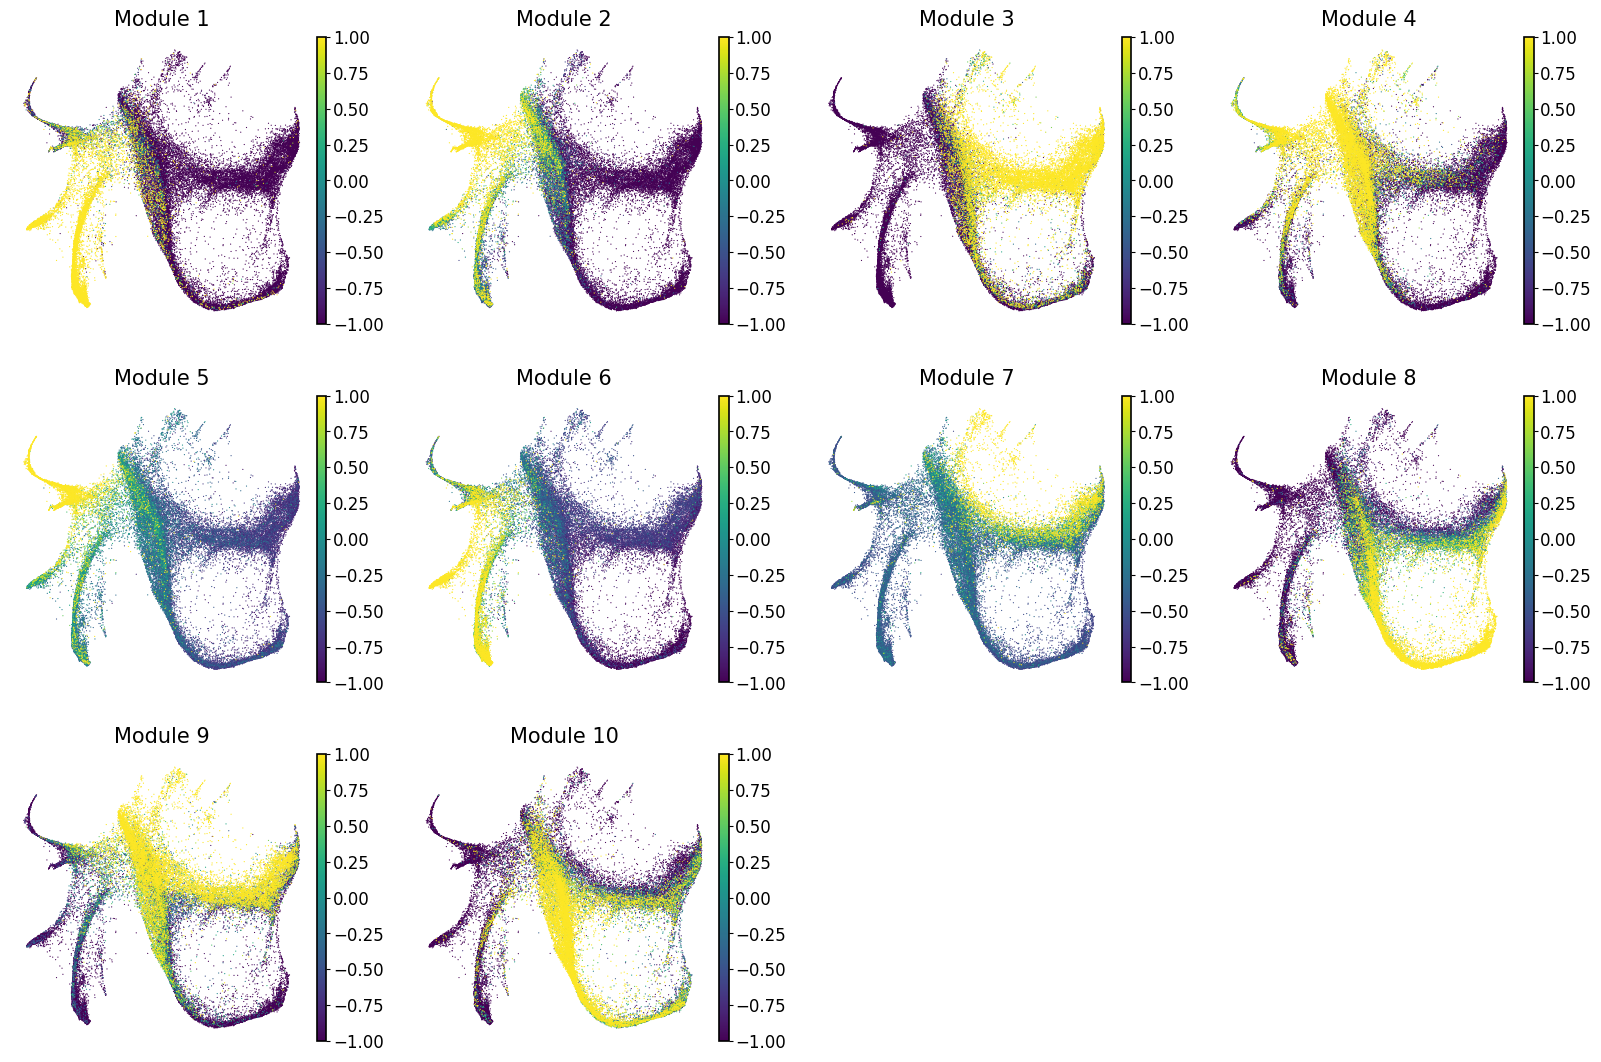

In [32]:
with mplscience.style_context():
    sc.pl.embedding(adata,  basis='X_emb', color=module_cols, frameon=False, vmin=-1, vmax=1)